# **Table of Contents**
#### **Step_0: import the libraries**

#### **Step_1: preparing the images (creating dataframes & generators)**

#### **Step_2: Visualization**

#### **Step_3: Model Development**

#### **Step_4: Evaluation of the model on the test set: Accuracy, Recall, Precision, f1_score**

**the dataset source:** [https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia](http://)

## **Step_0: import the libraries**

In [119]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras.preprocessing import image
import tensorflow as tf

## **Step_1: preparing the images** (creating dataframes & generators)



###   **1- Creating the dataframes**

In [2]:
train_dir= Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test_dir = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val_dir  = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

In [120]:
#create the lists of filespaths from the 3 directories: train,test and val
files_path_train= list(train_dir.glob(r'*/*.jpeg'))
files_path_test= list(test_dir.glob(r'*/*.jpeg'))
files_path_val = list(val_dir.glob(r'*/*.jpeg'))

In [4]:
#create the lists of lables for each filepath
labels_train= list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_train)) 
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_test))
labels_val= list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_val))

In [5]:
#create the columns for the dataframes
labels_train= pd.Series(labels_train, name= 'Label')
labels_test= pd.Series(labels_test, name= 'Label')
labels_val = pd.Series(labels_val, name= 'Label')

images_train= pd.Series(files_path_train, name= 'Filepath').astype(str)
images_test = pd.Series(files_path_test, name= 'Filepath').astype(str)
images_val = pd.Series(files_path_val, name= 'Filepath').astype(str)

In [6]:
#create the dataframes
train_df= pd.concat([images_train, labels_train], axis=1)
test_df = pd.concat([images_test, labels_test], axis=1)
val_df= pd.concat([images_val, labels_val], axis=1)

In [7]:
train_df.head()

,Filepath,Label
0,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA


In [8]:
test_df.tail()

,Filepath,Label
619,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL
620,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL
621,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL
622,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL
623,../input/chest-xray-pneumonia/chest_xray/chest...,NORMAL


In [9]:
val_df.head()

,Filepath,Label
0,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
1,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
2,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
3,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA
4,../input/chest-xray-pneumonia/chest_xray/chest...,PNEUMONIA


In [10]:
#checking the number of images 
print(len(train_df))
print(len(val_df))
print(len(test_df))


5216
16
624


In [11]:
#checking the images shapes
shapes_0=[]
shapes_1=[]
for filepath in train_df['Filepath'].values:
    img= imread(filepath)
    shapes_0.append(img.shape[0])
    shapes_1.append(img.shape[1])


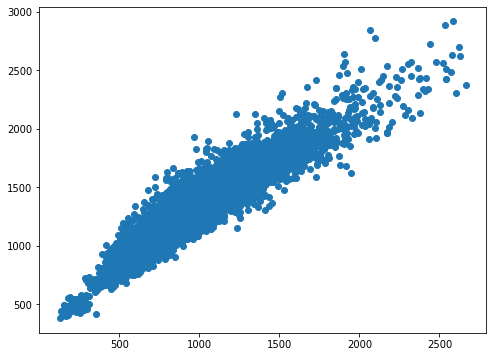

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(shapes_0, shapes_1);

 ### **2- Creating the generators**


We have 3 datasets: one for **train images**, one for **val images** the other for **test images**.We can now porceed with image preprocessing: we modify the images to be better suited for our **training model**.

* For this, we will use the Keras **ImageDataGenerator** to perform **data preprocessing and data augmentation.**

* we will also use the generators to **transform the values** in each batch, so taht **their mean is 0** and their **standard deviation is 1** (this will facilitate model training by standardizing the input distribution.

* the generator will also, automatically,  convert our **single channel chest x_ray** images (gray scale) to **three channel format** by repeating the pixel values in the images across all the channels (we will use this because the pretrained model that we will use require three channel inputs)


In [13]:
def train_images_gen (train_df, x_col, label_col,b_size=32,w=300, h= 300):
    """
    returns generator for training set, normlizing using batch statistics.
    Args:
    
    df: dataframe specifying training data
    x_col: name of column in df that holds filenames
    label_col: name of labels column
    b_size: images per batch to be fed into model during training set
    w: image target width
    h: image target height
    
    Returns:
    train_images (DataFrameIterator): iterator over training set
    """
    #create an ImageDataGenerator object normalizing the images
    train_gen = ImageDataGenerator(samplewise_center= True,
                                       samplewise_std_normalization= True)
    #flow from directory with specified batch size and target image size
    train_images = train_gen.flow_from_dataframe(dataframe= train_df,
                                                  x_col= x_col,
                                                  y_col= label_col,
                                                  class_mode= 'binary',
                                                  batch_size= b_size,
                                                  shuffle=True,
                                                  target_size=(w,h))
    return train_images


**Now, we build a seperate generator for test & valid sets:**

we should not use the same generator as for the training data, because **knowing the average per batch of our test data** will give our model an **adavantage** (the model should not have any information about the test data (in order to avoid **data leakage**) What we need to do is normalizing test data with **the statistics computed from training set**

* we implement this in this function below
* There is one **technical issue**: ideally, we would want compute the **sample mean** and the **sample standrad deviation** using the **entire training set**
* However, since the train set is **large**, we couldn't process this in this environment
* Solution: we will take a **random** from the train set and compute the **sample mean** and **sample standrad deviation.**

In [14]:
def test_valid_images_gen (test_df,valid_df,train_df,x_col,label_col, b_size=32,w=300, h=300,\
                    sample_size= 100 ):
    """
    returns generator for validation & test set using normalization statistics from training set
    Args:
    test_df: dataframe specifying testing data
    train_df: dataframe specifying training data 
    x_col: name of column in df that holds filenames
    label_col: name of labels column
    b_size: images per batch to be fed into model during training set
    w: image target width
    h: image target height
    
    returns:
    test_images & valid_images (DataFrameIterators): iterators over test set
    """
    
    #get generator to sample dataset
    train_images_sample = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        x_col="Filepath", 
        y_col="Label", 
        class_mode="binary", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(w,h))
    #get data sample
    batch= train_images_sample.next()
    data_sample= batch[0]
    
    #use the sample to fit mean & std to the test set generator
    test_valid_gen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    test_valid_gen.fit(data_sample)
    
    #get the test generator & valid generators
    test_images= test_valid_gen.flow_from_dataframe(dataframe= test_df,
                                                       x_col=x_col,
                                                       y_col= label_col,
                                                       class_mode='binary',
                                                       batch_size= b_size,
                                                       target_size=(w,h),
                                                       shuffle=False)
    valid_images= test_valid_gen.flow_from_dataframe(dataframe= valid_df,
                                                    x_col= x_col,
                                                    y_col= label_col,
                                                    class_mode= 'binary',
                                                    batch_size= b_size,
                                                    target_size=(w,h),
                                                    shuffle=False)
    return test_images,valid_images
    

In [15]:
train_images= train_images_gen(train_df, 'Filepath', 'Label')
test_images, valid_images = test_valid_images_gen (test_df,val_df,train_df,'Filepath','Label')

Found 5216 validated image filenames belonging to 2 classes.
Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


## **Step_2: Visualization**

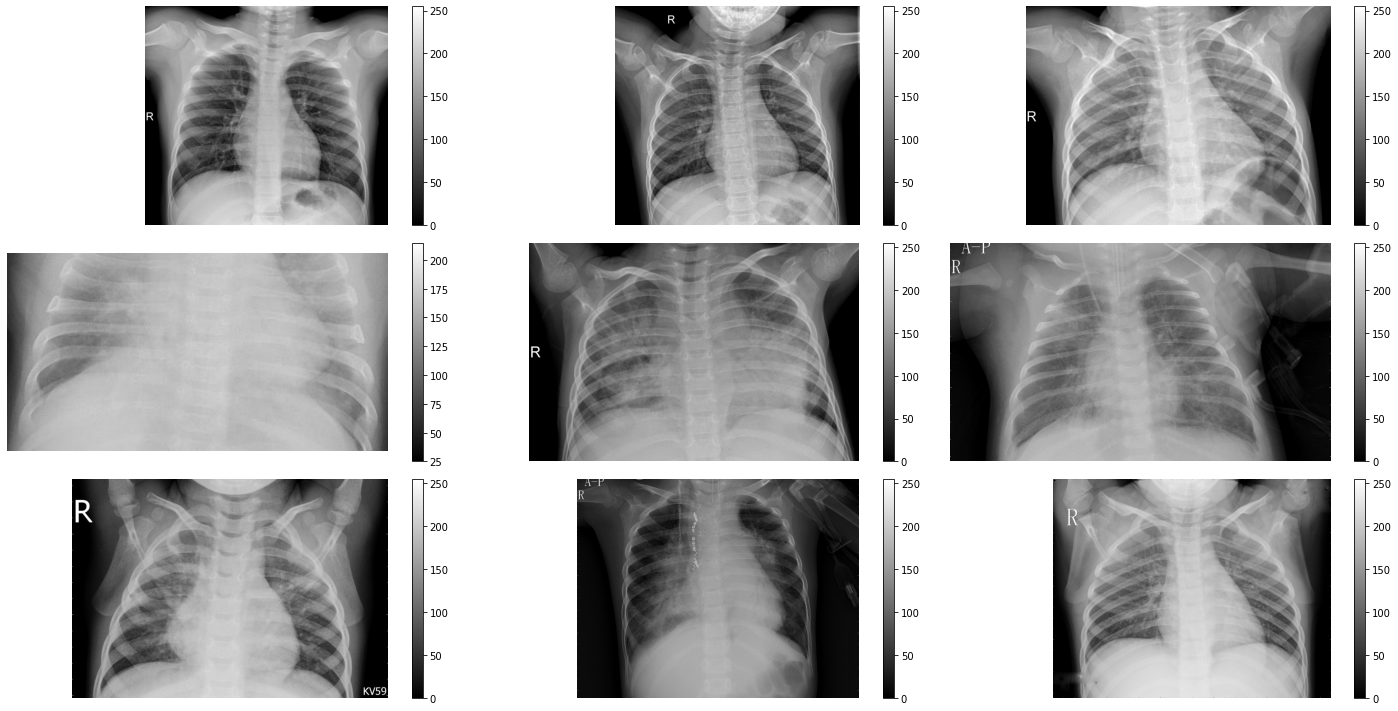

In [121]:
#visualization of some chest x-ray images from the train dataset

train_images_files= train_df['Filepath'].values

random_images= [np.random.choice(train_images_files) for i in range(9)]

%matplotlib inline
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    img= imread(random_images[i])
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.colorbar()
plt.tight_layout()

## **Step_3: Model Development**


 ### **1- Addressing Class Imbalance**

In [17]:
list_labels= list(train_df['Label'].value_counts().index)
list_labels

['PNEUMONIA', 'NORMAL']

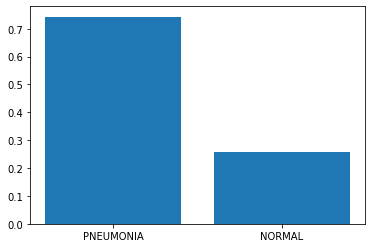

In [18]:
#Checking whether we have class imbalance

plt.bar(x=list_labels, height= \
        [np.mean(train_df['Label']=='PNEUMONIA'), np.mean(train_df['Label']=='NORMAL') ]);
#yes we have class imbalance

Ideally, we would train our model using an evenly **balanced dataset** so that the positive and negative training cases would **contribute equally to the loss.**

If we use a normal cross-entropy loss function with a highly **unbalanced dataset**, as we see above, the algorithm will be incentivized to **prioritize the majority class** (**positive(PNEUMONIA)** in our case), since it contributes more to the loss.

So, we will **transform the loss function** to a **weighted one**:

The loss is made up of two terms: for each training example i: 

**loss(i)= loss(i)neg + loss(i)pos**

**loss(i)neg = -1* weight_pos(i) * y(i) *log(f(x(i))**

**loss(i)pos = -1* weight_neg(i) * (1- y(i))* log(1-f(x(i))**

with:
**loss(i)pos**: refers to the loss where the actual label is positive (the same for loss(i)neg...)

**y(i):** the actaul label

**f(x(i)):** the predicted label

And : 

**weight_pos** = frequency of **negative** examples = number of negative examples/N

**weight_neg** = frequency of **positive** examples = number of positive examples/N

**N**: total number of examples 


**Explanation :** 
in our case, the contributions of **negative cases(normal)** will significantly be **lower** than that of the **positive** ones. However, we want the contributions to be **equal**. One way of doing this is by multiplying each example from each class by a **class-specific weight factor**: **weight_pos & weight_neg**: so that the overall contribution of each class is the **same**. To have this like saying: 

**weight_pos* pos_frquency = weight_neg * neg_frequency** 

so: 
**weight_pos = neg_frequency**

**weight_neg = pos_frquency**

We define a function that computes the two terms:
- weight_pos
- weight_neg


In [19]:
def get_class_weights(labels):
    """
    computes the postive weight and negative weight for each calss
    Args:
        labels: matrix or column vector(if it is about only 2 classes)
    Returns:
        weight_pos & weight_neg: for each class: vector pr scalar(if it is about only 2 classes)
    """
    weight_neg = np.sum(labels)/len(labels)
    weight_pos= 1-weight_neg 
    return weight_pos, weight_neg

In [21]:
positive_weights, negative_weights= get_class_weights(train_images.labels)

In [22]:
print("positive_weights are : {:.3}".format(positive_weights))
print("negative_weights are : {:.3}".format(negative_weights))

positive_weights are : 0.257
negative_weights are : 0.743


- then we define a function that computes the weighted loss:

In [23]:
def get_weighted_loss_binary(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): scalar weights for the positive class
      neg_weights (np.array): scalar weights for the negative class
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples,1)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, 1)
        Returns:
            loss (Float): overall scalar loss 
        """
        loss = 0.0
        #we add epsilon to avoid an error if y_pred (is 0)
        loss +=(-1*pos_weights*y_true* K.log(y_pred+epsilon)+ \
            -1*neg_weights*(1-y_true)* K.log(1-y_pred+epsilon))

        return loss
    
    return weighted_loss

### **2- Building & training the model**

- since the number of examples required to train medcial models for diagnosis is between 10.000 and 100.000, we will use **Transfer Learning** to build our model (because the number of our training examples doesn't exceed 5216 examples)

- we will use se a pre-trained **DenseNet121** model which we can load directly from Keras and then add  layers on top of it:

- for a detailed explanation of DenseNet, check this source: [https://arxiv.org/pdf/1608.06993.pdf](http://)

- we can download the pretrained weights from this link kaggle: [https://www.kaggle.com/xhlulu/densenet-keras](http://)


In [31]:
#create the base pretrained model
base_model = DenseNet121(weights='../input/densenet/densenet.hdf5',\
                         include_top= False)
x= base_model.output

#add global spatial average pooling
x= GlobalAveragePooling2D()(x)

#add the output layer
predictions= Dense(units= 1, activation ="sigmoid")(x)

#create the model
model= Model(inputs= base_model.input, outputs=predictions )

#compile the model
model.compile(optimizer= 'adam', loss=get_weighted_loss_binary(positive_weights, negative_weights),\
             metrics= ['accuracy'])



In [32]:
history = model.fit(train_images,
                    epochs= 5,
                    validation_data=valid_images,
                    steps_per_epoch=100,
                    validation_steps=2)
                              

Epoch 1/5
100/100 [==============================] - 2674s 26s/step - loss: 0.0846 - accuracy: 0.9197 - val_loss: 5.9219 - val_accuracy: 0.5000
Epoch 2/5
100/100 [==============================] - 2638s 26s/step - loss: 0.0339 - accuracy: 0.9639
Epoch 3/5
100/100 [==============================] - 2660s 27s/step - loss: 0.0248 - accuracy: 0.9741
Epoch 4/5
100/100 [==============================] - 2549s 25s/step - loss: 0.0235 - accuracy: 0.9749
Epoch 5/5
100/100 [==============================] - 2509s 25s/step - loss: 0.0217 - accuracy: 0.9817


## **Step_4: Evaluation of the model on the test set: accuracy, recall, precision, f1_score**

#### **1- Important: What is the best metric that reveals the model performance?** 


**it is important** to choose **metric** that matches **the goal** of our **Model**. 

In our case, the **accuracy is not the best metric**.Indeed, we have to detect **pneumonia cases**, so we msut choose a model(classifier) that **maximizes the recall (TP/TP+FN): the ability of the model to predict positive cases** (even if it will classify some negative cases as positive: **"no matter"**): 

**the Goal** is  to **detect the maximum of positive cases (having pneumonia)**. 

the **precision** is also a major metric, but it is not as important as the **recall(in our case)**, in other words, if it is about **detecting credit card frauds**: yes,we should focus on the precision(because we must be careful not to calssify a non-fraudulent(negative) case as fraudulent(positive)). 

**f1-score** is a balance between these two metrics **recall(sensitivity) & precision**. 
Below, we give **all these metrics** that reveal the performance of our model.


#### **2-  Accuracy on the validation_set(just for recall)**

In [47]:
#Evaluate the model on the validation set:
#it is predictible that the accuracy on the validation set is high because the 
#set size is so small (only 16 images, compared to 5216 images for the train set):
#And the sizes are fixed by the author
model.evaluate(valid_images)

1/1 [==============================] - 2s 2s/step - loss: 0.0131 - accuracy: 1.0000


[0.013101071119308472, 1.0]

#### **3- Evaluation: Accuracy on the test_set (but accuracy is not the best performance metric in our case)**

In [49]:
Results= model.evaluate(test_images)
Results

20/20 [==============================] - 93s 5s/step - loss: 0.2740 - accuracy: 0.8798


[0.2740052342414856, 0.879807710647583]

In [54]:
print("The Loss on the test set is: {:.3f}".format(Results[0]))
print("The accuracy on the test set is: {:.1f}%".format(Results[1]*100))

The Loss on the test set is: 0.274
The accuracy on the test set is: 88.0%


#### **4- Predictions (on the test_set) & the best performance metrics: recall, f1-score**

In [41]:
proba_predictions= model.predict(test_images)

In [84]:
#Checking the calss indices: 0: negative cases(NORMAL) & 1: positive cases (PNEUMONIA)
dict_classes= train_images.class_indices
dict_classes

{'NORMAL': 0, 'PNEUMONIA': 1}

In [66]:
y_true= test_images.classes
y_predictions= (proba_predictions > 0.5).astype('int32')

In [70]:
print(classification_report(y_true,y_predictions ))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       234
           1       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.86       624
weighted avg       0.89      0.88      0.88       624



#### **Results:**
- The **recall (Sensitivity)**: **The ability** of the model to predcit positive case: **98%**

- The **f1-score** is **91%** (balance between precision & recall)

=> **our model achieves a high performance (of 98%) to predict positive cases**

#### **5- Visualization of Results:**

In [87]:
cm= confusion_matrix(y_true,y_predictions)
df_cm= pd.DataFrame(cm, index= list(dict_classes.keys()), columns=list(dict_classes.keys()) )
df_cm

,NORMAL,PNEUMONIA
NORMAL,166,68
PNEUMONIA,7,383


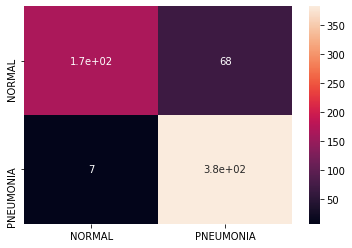

In [90]:
sns.heatmap(df_cm, annot=True);
#we notice that only 7 positive cases are classified as normal and 383 penumonia cases from 390,
#have been properly classified as positive cases (98%): high performance 
#it is true that 68 normal cases are classified as positive cases (but as I said above, the goal 
#of our model,is to detect the maximum of positive cases(to help doctors to identify sick subjects))
#if it is about detecting credit card frauds,it will be worrying(because we must have high precision)

#### **6- Prediction on an image from test set (chosen randomly) :**

In [95]:
my_image_path= np.random.choice(test_df['Filepath'].values)
my_image= image.load_img(my_image_path)
my_image_arr= image.img_to_array(my_image)

In [116]:
#Check the true label of our random image 
#as we see, it is positive case (so label= 1)
for index, row in test_df.iterrows():
    if row['Filepath']== my_image_path:
        print(row['Label'])

PNEUMONIA


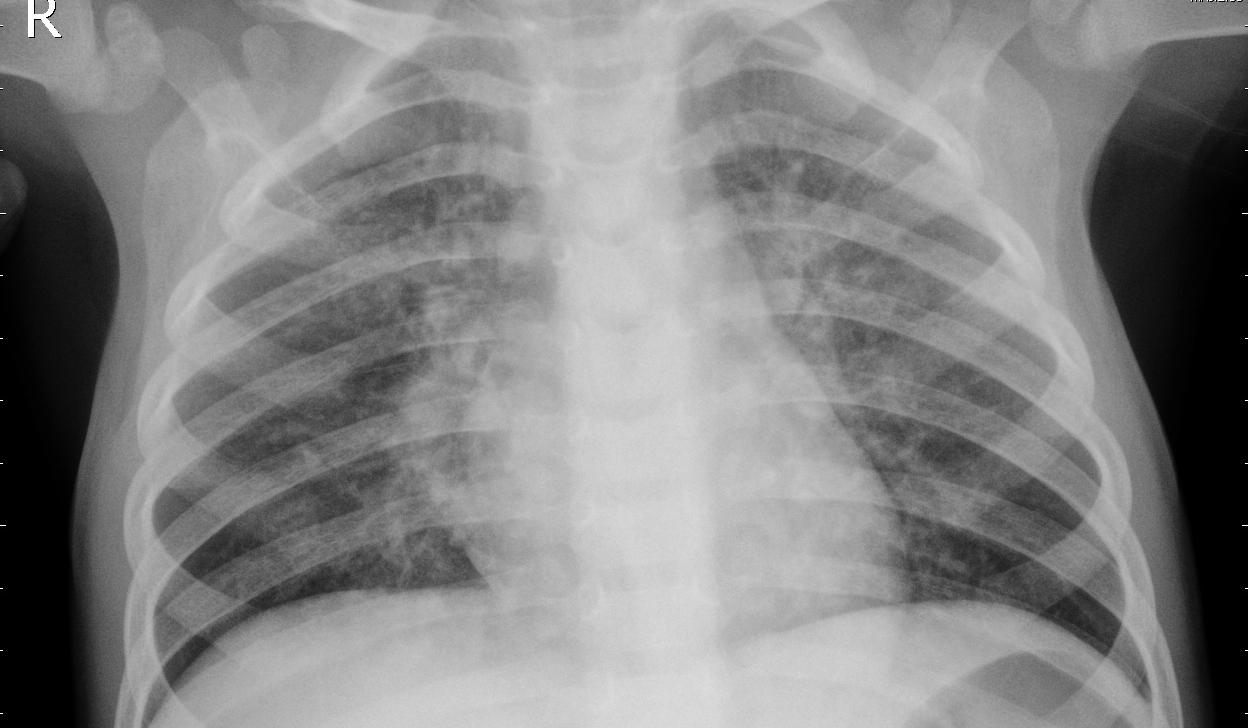

In [96]:
my_image

In [98]:
my_image_arr.shape

(728, 1248, 3)

In [105]:
#to have the same size as the trained images
my_image = tf.image.random_crop(my_image_arr,[300, 300, 3]) 

#to have the same shape as the trained images

my_image= np.expand_dims(my_image, axis=0)
print(my_image.shape)

(1, 300, 300, 3)


In [115]:
(model.predict(my_image)>0.5).astype('int32')

array([[1]], dtype=int32)

=> **So the model correctly predicts this random image from the test set as a positive case**